In [2]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 7.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


/home/minyu/miniconda3/envs/tomo-env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Sinogram shape: (1719, 1746)


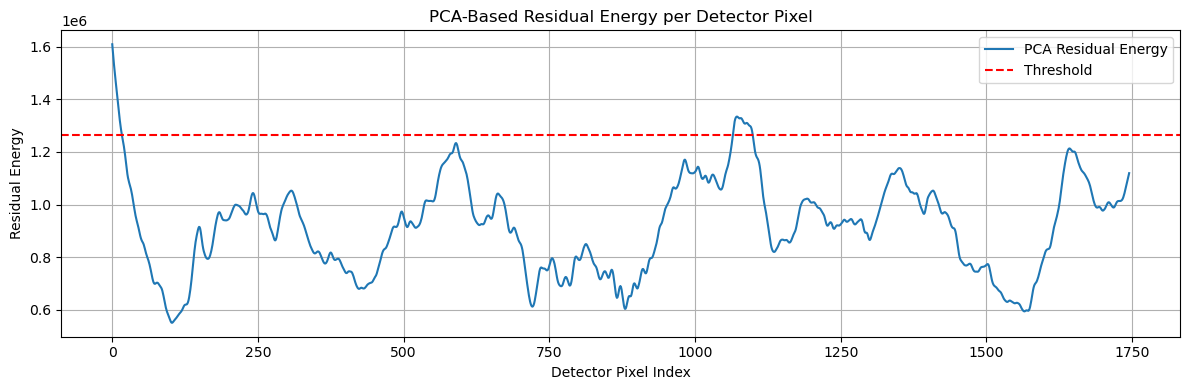

🧼 Total detector bins flagged for correction: 81
🛠️ Final bin indices: [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16  909  910  911  912  913  914  915  916  917  918  923
  924  925  926  927  928  929  930  931  932  937  938  939  940  941
  942  943  944  945  946 1065 1066 1067 1068 1069 1070 1071 1072 1073
 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087
 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098]
🚨 PCA-flagged detector bins with high residual energy:
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075
 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089
 1090 1091 1092 1093 1094 1095 1096 1097 1098]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.transform import radon
import tifffile

# === Step 1: Load a representative slice from your TIFF stack ===
stack = tifffile.imread("recon_025_AS1.6_4DPF_WB_18x(361nm).tiff")
mid = stack.shape[0] // 2
slice_img = stack[mid].astype(np.float32)
slice_img /= np.max(slice_img)

# === Step 2: Compute sinogram (Radon transform) ===
theta = np.linspace(0., 180., max(slice_img.shape), endpoint=False)
sinogram = radon(slice_img, theta=theta, circle=True)  # shape: (num_angles, num_detectors)
cropped_sinogram = sinogram[:, 24:1770]
print("Sinogram shape:", cropped_sinogram.shape)

# === Step 3: PCA analysis on sinogram columns ===
pca = PCA(n_components=5)  # capture dominant structure only
X_reduced = pca.fit_transform(cropped_sinogram)              # shape: (angles, PCs)
X_reconstructed = pca.inverse_transform(X_reduced)   # shape: (angles, detectors)
residual = cropped_sinogram - X_reconstructed

# === Step 4: Compute residual energy for each detector column ===
residual_energy = np.sum(residual**2, axis=0)  # one value per detector bin

# === Step 5: Plot residual energy ===
plt.figure(figsize=(12, 4))
plt.plot(residual_energy, label="PCA Residual Energy")
plt.axhline(np.mean(residual_energy) + 2*np.std(residual_energy), color='red', linestyle='--', label='Threshold')
plt.title("PCA-Based Residual Energy per Detector Pixel")
plt.xlabel("Detector Pixel Index")
plt.ylabel("Residual Energy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 6: Flag bad bins based on threshold (2σ above mean) ===
# --- Threshold-based PCA bin detection ---
pca_threshold = np.mean(residual_energy) + 2 * np.std(residual_energy)
bad_bins_pca = np.where(residual_energy > pca_threshold)[0]

# --- Manual bad bins (from sinogram residual analysis) ---
manual_bad_bins = np.array([
    909, 910, 911, 912, 913, 914, 915, 916, 917, 918,
    923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
    937, 938, 939, 940, 941, 942, 943, 944, 945, 946
])

# --- Extended anomaly cluster from PCA (new discovery) ---
extended_core_cluster = np.arange(1065, 1099)  # Inclusive of 1098

# --- Combine and deduplicate all flagged bins ---
bad_bins_combined = np.unique(np.concatenate([
    manual_bad_bins,
    extended_core_cluster,
    bad_bins_pca
]))

print(f"🧼 Total detector bins flagged for correction: {len(bad_bins_combined)}")
print("🛠️ Final bin indices:", bad_bins_combined)

# --- Interpolate each bad detector column in the sinogram ---
for i in bad_bins_combined:
    if 2 < i < sinogram.shape[1] - 3:  # Avoid boundary overflow
        sinogram[:, i] = (
            0.25 * sinogram[:, i - 2] +
            0.5  * sinogram[:, i - 1] +
            0.5  * sinogram[:, i + 1] +
            0.25 * sinogram[:, i + 2]
        ) / 1.5




print("🚨 PCA-flagged detector bins with high residual energy:")
print(bad_bins_pca)
